In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from scipy.stats import multivariate_normal, bernoulli, uniform
from sklearn.utils import resample
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier, GradientBoostingClassifier

%matplotlib inline
warnings.filterwarnings('ignore')

np.random.seed(42)

In [ ]:
def make_samples(n,p=5):
    cov = np.ones((p, p)) * 0.95 + np.eye(p) * (1 - 0.95)
    X = multivariate_normal(mean = np.zeros(p), cov = cov).rvs(n)

    y = np.zeros(n)
    m1 = sum(X[:,0] <= 0.5)
    m2 = n - m1
    y[X[:,0] <= 0.5] = bernoulli(0.2).rvs(m1)
    y[X[:,0] > 0.5] = bernoulli(0.8).rvs(m2)
    return X, y


In [ ]:
X_train, y_train = make_samples(30)
X_test, y_test = make_samples(2000)

clf = DecisionTreeClassifier(max_depth=2)

clf.fit(X_train, y_train)

origin_err = 1 - np.mean(y_test == clf.predict(X_test))
origin_err

0.41700000000000004

In [ ]:
class Bagging:
    def __init__(self, B):
        self.B = B
        self.base_model = DecisionTreeClassifier(max_depth=2)
        self.bootstraped_models = []

    def fit(self, X, y):
        clf = self.base_model
        clf.fit(X, y)
        self.bootstraped_models.append(clf)

        for _ in range(1, self.B):
            X_re, y_re = resample(X, y)
            clf = DecisionTreeClassifier(max_depth=2)
            clf.fit(X_re, y_re)
            self.bootstraped_models.append(clf)

    def predict(self, X, method = 'votes'):
        if method == 'votes':
            predictions = [clf.predict(X) for clf in self.bootstraped_models]
            majority_votes = np.apply_along_axis(lambda x: np.bincount(x.astype(int)).argmax(), axis=0, arr=predictions)
            return majority_votes

        elif method == 'probability':
            probas = [clf.predict_proba(X) for clf in self.bootstraped_models]
            avg_proba = np.apply_along_axis(lambda x: np.mean(x), axis=0, arr=probas)
            predictions = np.argmax(avg_proba,axis=1)
            return predictions

In [ ]:
vote_err = np.zeros(200)
prob_err = np.zeros(200)

vote_err[0] = origin_err
prob_err[0] = origin_err

for b in range(1, 200):
    bag_clf = Bagging(B=b+1)
    bag_clf.fit(X_train, y_train)
    vote_err[b] = 1 - np.mean(y_test == bag_clf.predict(X_test, "votes"))
    prob_err[b] = 1 - np.mean(y_test == bag_clf.predict(X_test, "probability"))

In [ ]:
vote_err

array([0.417 , 0.375 , 0.31  , 0.38  , 0.331 , 0.2875, 0.3255, 0.3305,
       0.3195, 0.2865, 0.31  , 0.3345, 0.3335, 0.3145, 0.3265, 0.296 ,
       0.321 , 0.308 , 0.3335, 0.295 , 0.3165, 0.2995, 0.3095, 0.3145,
       0.293 , 0.301 , 0.292 , 0.325 , 0.3   , 0.286 , 0.311 , 0.3065,
       0.297 , 0.392 , 0.324 , 0.3   , 0.304 , 0.299 , 0.3195, 0.311 ,
       0.3035, 0.3125, 0.319 , 0.324 , 0.3225, 0.318 , 0.3195, 0.3245,
       0.3035, 0.315 , 0.32  , 0.313 , 0.317 , 0.306 , 0.312 , 0.315 ,
       0.3225, 0.3215, 0.2935, 0.306 , 0.3195, 0.3035, 0.322 , 0.3085,
       0.3275, 0.317 , 0.307 , 0.3025, 0.3085, 0.308 , 0.329 , 0.3165,
       0.313 , 0.325 , 0.326 , 0.3125, 0.329 , 0.308 , 0.317 , 0.31  ,
       0.307 , 0.313 , 0.324 , 0.311 , 0.306 , 0.314 , 0.3185, 0.319 ,
       0.307 , 0.309 , 0.323 , 0.328 , 0.316 , 0.3215, 0.3245, 0.322 ,
       0.313 , 0.3285, 0.3205, 0.3105, 0.3115, 0.3275, 0.321 , 0.312 ,
       0.3075, 0.3105, 0.332 , 0.3075, 0.3215, 0.312 , 0.3155, 0.3155,
      

In [ ]:
prob_err

array([0.417 , 0.294 , 0.3085, 0.3205, 0.314 , 0.3175, 0.324 , 0.3345,
       0.3235, 0.311 , 0.311 , 0.334 , 0.3335, 0.3175, 0.325 , 0.309 ,
       0.321 , 0.3055, 0.3335, 0.29  , 0.3125, 0.3055, 0.311 , 0.3325,
       0.305 , 0.3065, 0.2885, 0.3295, 0.295 , 0.292 , 0.3105, 0.3175,
       0.302 , 0.3135, 0.328 , 0.3015, 0.3235, 0.301 , 0.318 , 0.3185,
       0.306 , 0.314 , 0.318 , 0.324 , 0.3315, 0.3125, 0.3135, 0.3285,
       0.308 , 0.316 , 0.32  , 0.3035, 0.317 , 0.3095, 0.313 , 0.31  ,
       0.328 , 0.3295, 0.2965, 0.3045, 0.318 , 0.314 , 0.322 , 0.3105,
       0.326 , 0.3185, 0.3085, 0.308 , 0.3125, 0.305 , 0.32  , 0.317 ,
       0.3095, 0.3255, 0.321 , 0.317 , 0.33  , 0.3225, 0.318 , 0.313 ,
       0.3085, 0.3245, 0.322 , 0.321 , 0.314 , 0.3205, 0.321 , 0.3245,
       0.3075, 0.307 , 0.325 , 0.331 , 0.325 , 0.3185, 0.3265, 0.321 ,
       0.3135, 0.33  , 0.3205, 0.312 , 0.3185, 0.329 , 0.3185, 0.3195,
       0.3155, 0.308 , 0.3295, 0.3075, 0.3205, 0.3155, 0.323 , 0.319 ,
      

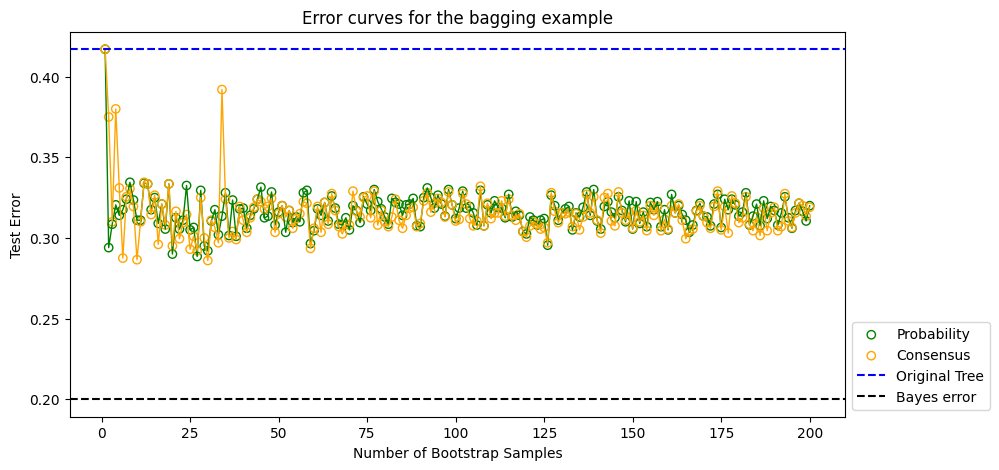

In [ ]:
plt.figure(figsize=(10,5))

plt.scatter(range(1,len(prob_err) + 1), prob_err, facecolors='none', edgecolors='green',label = 'Probability')
plt.plot(range(1,len(prob_err) + 1), prob_err, color='green', linewidth=1)

plt.scatter(range(1,len(vote_err) + 1), vote_err, facecolors='none', edgecolors='orange', label = 'Consensus')
plt.plot(range(1,len(vote_err) + 1), vote_err, color='orange', linewidth=1)

plt.axhline(y=origin_err, xmin=0, xmax=200, color='blue', linestyle='dashed', label='Original Tree')
plt.axhline(y=0.2, xmin=0, xmax=200, color='black', linestyle='dashed', label = 'Bayes error')

plt.legend(loc='lower left', bbox_to_anchor=(1.0,0))
plt.xlabel("Number of Bootstrap Samples")
plt.ylabel("Test Error")
plt.title("Error curves for the bagging example")
plt.show()

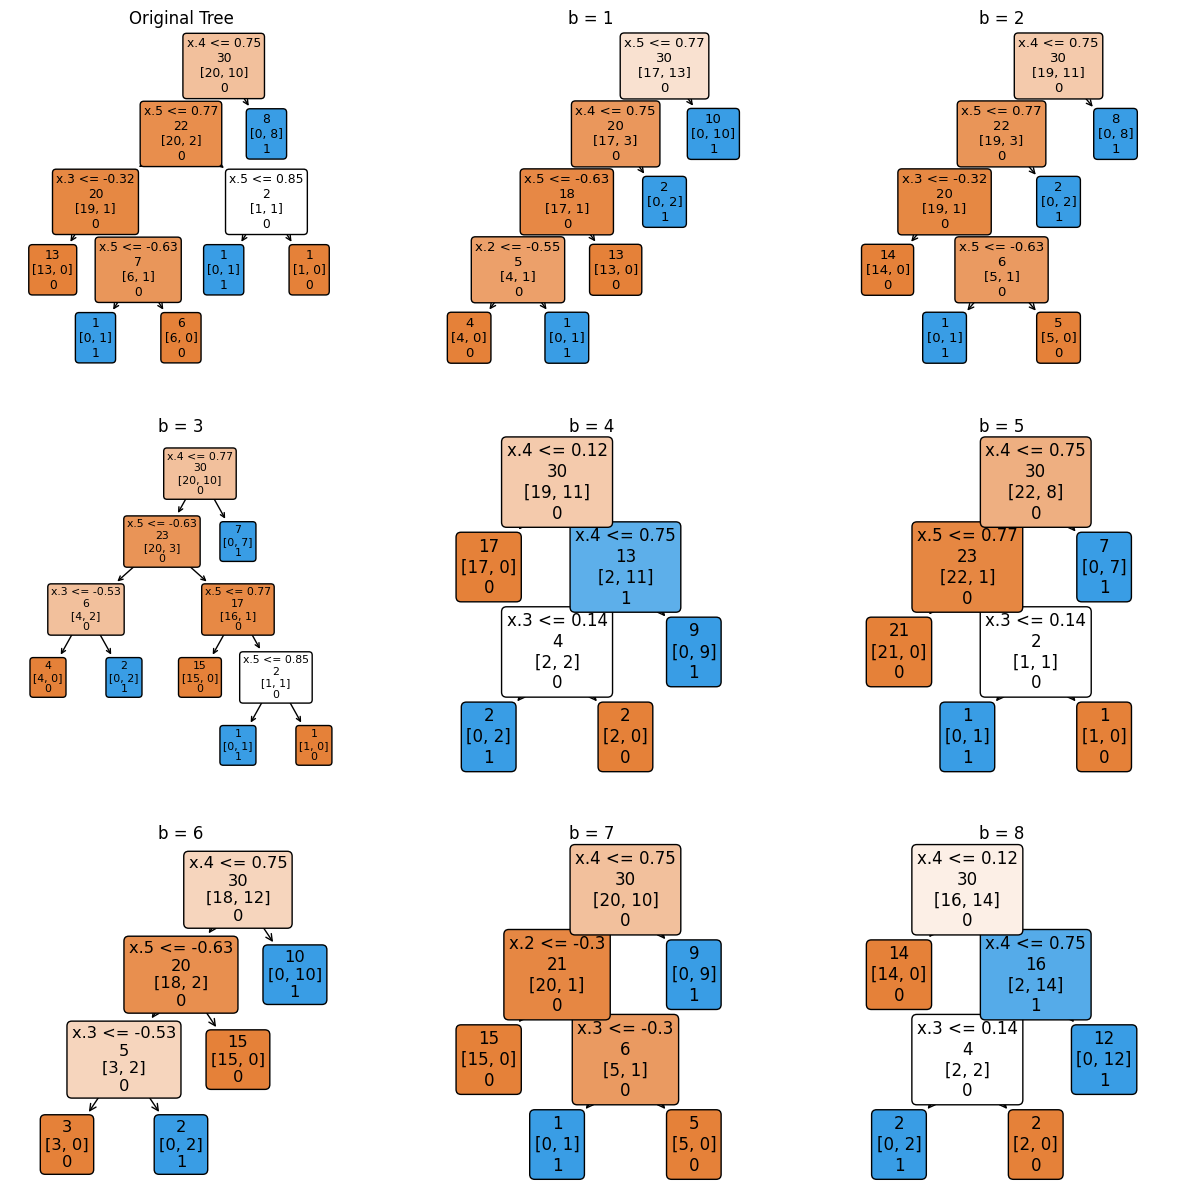

In [ ]:
yy = np.zeros(2000)
clf.fit(X_train, y_train)
yy += clf.predict(X_test)

fig = plt.figure(figsize=(15, 15))

plt.subplot(3,3,1)
tree.plot_tree(clf,
               feature_names=['x.1', 'x.2', 'x.3', 'x.4', 'x.5'],
               class_names=['0', '1'],
               filled=True,
               node_ids=False,  # Turn off the display of node IDs
               impurity=False,  # Turn off the display of impurity
               label=None,      # Turn off the display of the node labels
               proportion=False,  # Turn off the display of class proportions
               rounded=True,    # Round the corners of the nodes
               precision=2      # Set the precision for display
              )
plt.title('Original Tree')


for i in range(199):
    idx = resample(range(len(X_train)))
    X_re = X_train[idx]
    y_re = y_train[idx]
    clf = DecisionTreeClassifier(random_state=42)
    clf.fit(X_re, y_re)
    yy += clf.predict(X_test)

    if i < 8:
        plt.subplot(3,3,i+2)
        tree.plot_tree(clf,
               feature_names=['x.1', 'x.2', 'x.3', 'x.4', 'x.5'],
               class_names=['0', '1'],
               filled=True,
               node_ids=False,  # Turn off the display of node IDs
               impurity=False,  # Turn off the display of impurity
               label=None,      # Turn off the display of the node labels
               proportion=False,  # Turn off the display of class proportions
               rounded=True,    # Round the corners of the nodes
               precision=2      # Set the precision for display
              )
        plt.title('b = {}'.format(i+1))

plt.show()

# Bagging vs Boosting

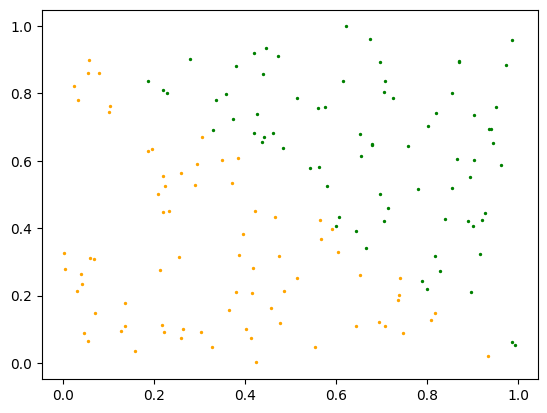

In [ ]:
n = 150
x1 = uniform(0,1).rvs(n).reshape(-1,1)
x2 = uniform(0,1).rvs(n).reshape(-1,1)
y = np.zeros((n,1))
y[x1+x2 > 1] = 1

X = np.hstack([x1,x2])

plt.scatter(x1[x1+x2>1],x2[x1+x2>1], color='green', s=2)
plt.scatter(x1[x1+x2<=1],x2[x1+x2<=1], color='orange', s=2)
plt.show()

In [7]:
uniform(-1,2).rvs(10)

array([ 0.73693595, -0.0251376 ,  0.78910445,  0.59971051, -0.14957299,
       -0.95506138, -0.46264528,  0.08326843,  0.26695644, -0.48422463])

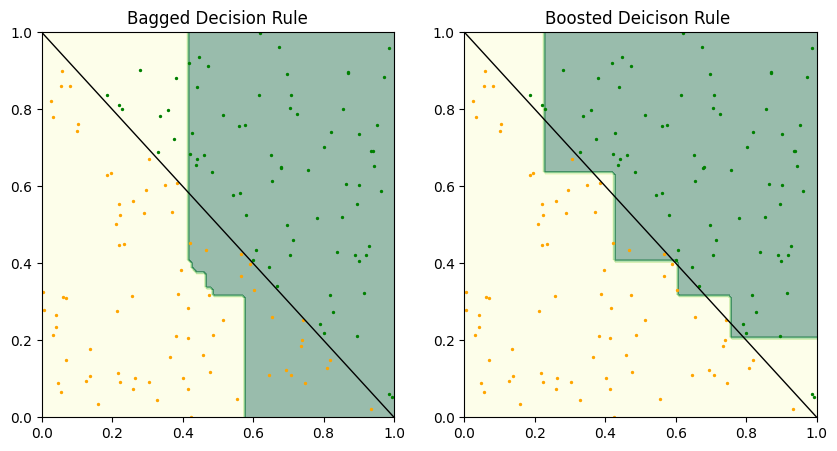

In [ ]:
clf = DecisionTreeClassifier(max_depth=1)
bagged_clf = BaggingClassifier(clf, n_estimators=50).fit(X,y)
boosted_clf = GradientBoostingClassifier(n_estimators=50, max_depth=1).fit(X, y)

xx, yy = np.meshgrid(np.arange(0, 1.01, 0.01), np.arange(0, 1.01, 0.01))

Z1 = bagged_clf.predict(np.c_[xx.ravel(), yy.ravel()]).reshape(xx.shape)
Z2 = boosted_clf.predict(np.c_[xx.ravel(), yy.ravel()]).reshape(xx.shape)

x1_t = uniform(0,1).rvs(2000).reshape(-1,1)
x2_t = uniform(0,1).rvs(2000).reshape(-1,1)
y_test = np.zeros((2000,1))
y_test[x1_t+x2_t > 1] = 1
X_test = np.hstack([x1_t, x2_t])

y_pred_bagged = bagged_clf.predict(X_test)
y_pred_boosted = boosted_clf.predict(X_test)

plt.figure(figsize=(10,5))

plt.subplot(121)
plt.contourf(xx, yy, Z1, alpha=0.4, cmap='YlGn')
plt.scatter(x1[x1+x2>1],x2[x1+x2>1], color='green', s=2)
plt.scatter(x1[x1+x2<=1],x2[x1+x2<=1], color='orange', s=2)
plt.plot([0,1],[1,0], color='black', linewidth=1)
plt.title("Bagged Decision Rule")

plt.subplot(122)
plt.contourf(xx, yy, Z2, alpha=0.4, cmap='YlGn')
plt.scatter(x1[x1+x2>1],x2[x1+x2>1], color='green', s=2)
plt.scatter(x1[x1+x2<=1],x2[x1+x2<=1], color='orange', s=2)
plt.plot([0,1],[1,0], color='black', linewidth=1)
plt.title("Boosted Deicison Rule ")

plt.show()